In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Linear interpolation of nulls. 
#First concat train and test, remove hopelessly null rows, split again, convert to float, then interpolate()

NULL_THRESHOLD = 97 #Elbow of NA values. Locations with 97 or more null values were hopeless for imputation

train = pd.read_csv('ground_measures_train_features.csv')
test = pd.read_csv('ground_measures_test_features.csv')

traintest = pd.concat([train, test], axis = 1)
traintest = traintest[traintest["2013-01-01"].isna() == False]   # Can't extrapolate, only interpolate, so no rows where the first/last dates are missing
traintest = traintest[traintest["2020-01-07"].isna() == False]
traintest = traintest[(traintest.isna().sum(axis=1) < NULL_THRESHOLD)] 

train2 = traintest.iloc[:, :214]
test2 = traintest.iloc[:, 214:] 
train2.iloc[:, 1:] = train2.iloc[:, 1:].astype(float).interpolate(axis=1) #interpolated values
test2.iloc[:, 1:] = test2.iloc[:, 1:].astype(float).interpolate(axis = 1)

train = train2
test = test2

In [3]:
train

,Unnamed: 0,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,0.116667,0.233333,0.35,0.466667,0.583333,0.70,1.20,3.40,3.70,3.40
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.520000,20.810000,8.71,0.300000,0.000000,5.69,8.04,10.74,12.67,12.57
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.840000,0.600000,0.36,0.360000,0.240000,2.88,4.56,4.68,5.04,6.00
5,CDEC:BFL,6.60,7.92,8.76,9.00,10.44,10.80,11.16,11.28,12.00,...,0.270000,0.150000,0.27,0.390000,0.270000,3.00,3.36,4.56,5.04,5.64
8,CDEC:BKL,16.56,17.04,18.72,19.20,19.08,20.16,21.72,22.32,24.36,...,6.360000,0.960000,2.40,3.840000,5.280000,6.72,5.88,6.12,10.56,11.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.000000,0.000000,0.00,0.000000,0.000000,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.000000,0.100000,0.00,0.000000,0.000000,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.000000,0.000000,0.00,0.000000,0.000000,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.600000,36.100000,31.30,8.500000,0.000000,8.00,9.00,13.20,23.70,25.00


In [4]:
# Keep names of train stations on names_train
names_train = train['Unnamed: 0']
train.drop(columns = 'Unnamed: 0', inplace=True)

# Also for test
names_test = test['Unnamed: 0']
test.drop(columns = 'Unnamed: 0', inplace=True)

# Transform index to datetime and rename
train.columns = pd.to_datetime(train.columns)
test.columns = pd.to_datetime(test.columns)

train_one = train
test_one = test

In [5]:
#Optional code for adding centroids and other metedata in 
"""train_coords = pd.read_csv("train_coords.csv")
train_coords = train_coords.rename(columns={"field_1":"Unnamed: 0"})
test_one_centroids = test_one.merge(train_coords) 
test_one_centroids.to_csv("test_534_with_centroids.csv")
test_one_centroids"""

'train_coords = pd.read_csv("train_coords.csv")\ntrain_coords = train_coords.rename(columns={"field_1":"Unnamed: 0"})\ntest_one_centroids = test_one.merge(train_coords) \ntest_one_centroids.to_csv("test_534_with_centroids.csv")\ntest_one_centroids'

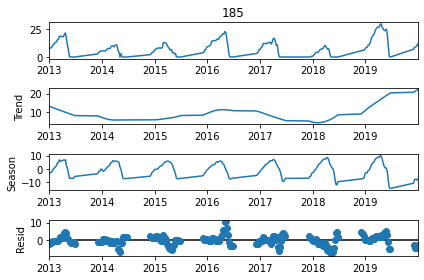

<Figure size 720x720 with 0 Axes>

In [6]:
from statsmodels.tsa.seasonal import STL  #Seasonal Decomposition for curiosity's sake
stl = STL(train_one.iloc[168, :], period=31)
res = stl.fit()
fig = res.plot()
plt.figure(figsize=[10,10])
plt.show()

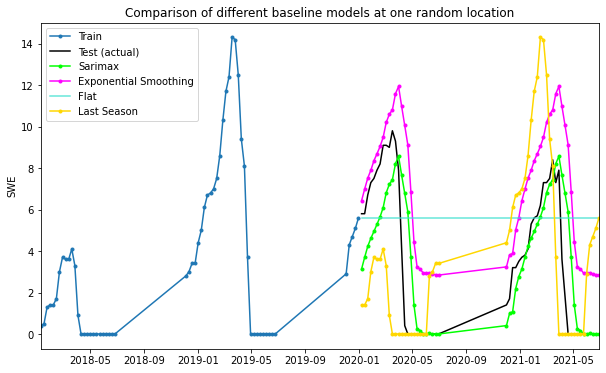

In [7]:
# THE MAIN CELL TO GRAPH DIFFERENT MODELS


station = 336   #Choose a single station to compare models/baselines

best_order = (0,0,0)
best_seasonal = (1,0,1,31)

model_ex = ExponentialSmoothing(train_one.iloc[station, :], seasonal='add', seasonal_periods=31).fit() #exponential smoothing model
model = SARIMAX(train_one.iloc[station, :], order=best_order, seasonal_order=best_seasonal).fit()      #SARIMAX

pred_ex = model_ex.predict(start=213, end=213+56)
pred_o = model.predict(start=213, end=213+56)

plt.figure(figsize=(10, 6))
plt.plot(train_one.columns, train_one.iloc[station, :], label='Train', marker = '.')
plt.plot(test_one.columns, test_one.iloc[station, :], label='Test (actual)', color = "black")
plt.plot(test_one.columns, pred_o, label='Sarimax', marker = '.', color = "lime")
plt.plot(test_one.columns, pred_ex, label='Exponential Smoothing', marker = '.', color = "magenta")

plt.plot(test_one.columns, [train_one.iloc[station, 212]]*57, label='Flat', color = "turquoise", alpha=0.8)  #Flat/random walk
plt.plot(test_one.columns, train_one.iloc[station, 212-56:], label="Last Season", color = "gold", marker = '.')  #Previous Season

plt.legend(loc='best')
plt.xlim(train_one.columns[-60], test_one.columns[-1])
plt.ylabel("SWE")
plt.title("Comparison of different baseline models at one random location")
plt.show()

In [8]:
colstest = pd.read_csv('ground_measures_train_features.csv')
colstest["Ind"] = colstest.index
colstest["Station"] = colstest['Unnamed: 0']
train_index = train_one.copy()
train_index["Ind"] = train_index.index
train_stations = train_index.merge(colstest, on = "Ind")

In [10]:
#### MAIN CELL USED TO GENERATE PREDICTIONS###

rws = []          #Store predicted rows, station id, best model for dataframe creation
ids = []
model_used = []


for i in range(train_one.shape[0]):
    model = SARIMAX(train_one.iloc[i, :], order=(0,0,0), seasonal_order=(1,0,1,31)).fit()
    model_es = ExponentialSmoothing(train_one.iloc[i, :], seasonal='add', seasonal_periods=31).fit()  
    
    pred = model.predict(start=213, end=213+56)
    pred_es = model_es.predict(start=213, end=213+56)
    pred_flat = [train_one.iloc[i,212]]*57                     #Flat
    pred_mean = [train_one.iloc[i, :].mean()]*57                  #Mean
    pred_last_season = train_one.iloc[i, 212-56:].values              #Last Seasons
    preds = [pred.values, pred_es.values, pred_flat, pred_mean, pred_last_season]

    error_model = np.sqrt(np.sum((pred.values - test_one.iloc[i, :])**2)/len(pred))
    error_es = np.sqrt(np.sum((pred_es.values - test_one.iloc[i, :])**2)/len(pred))
    error_flat = np.sqrt(np.sum((pred_flat - test_one.iloc[i, :])**2)/len(pred))
    error_last_season = np.sqrt(np.sum((pred_last_season - test_one.iloc[i, :])**2)/len(pred))
    error_mean = np.sqrt(np.sum((pred_mean - test_one.iloc[i, :])**2)/len(pred))
    
    
    errors = {"sarimax":error_model, "exponential smoothing":error_es, "flat":error_flat, "last season":error_last_season, "mean":error_mean}
    best_model = np.argmin(list(errors.values()))
    model_used.append(list(errors.keys())[best_model])   #chooses best model
   
    rws.append(list(preds[best_model]))
    ids.append(train_stations.Station[i])
    if i%50 == 0:
        print(i)

                                              

0
50
100
150
200
250
300
350
400
450
500
550
600
650


In [11]:
df_pred_655 = pd.DataFrame(rws, columns=test_one.columns)
df_pred_655[df_pred_655 < 0] = 0
df_pred_655['Station'] = ids           
                              

In [12]:
df_pred_655.to_csv('Preds000_10131_655.csv')

In [13]:
df_pred_655

,2020-01-07 00:00:00,2020-01-14 00:00:00,2020-01-21 00:00:00,2020-01-28 00:00:00,2020-02-04 00:00:00,2020-02-11 00:00:00,2020-02-18 00:00:00,2020-02-25 00:00:00,2020-03-03 00:00:00,2020-03-10 00:00:00,...,2021-05-04 00:00:00,2021-05-11 00:00:00,2021-05-18 00:00:00,2021-05-25 00:00:00,2021-06-01 00:00:00,2021-06-08 00:00:00,2021-06-15 00:00:00,2021-06-22 00:00:00,2021-06-29 00:00:00,Station
0,2.516572,3.443257,3.843193,5.190492,6.136897,6.961072,7.835769,8.630745,9.104256,10.243210,...,2.753873,1.889073,0.981385,0.000000,0.028144,5.628829e-02,8.443243e-02,1.125766e-01,1.407207e-01,CDEC:ADM
1,12.570000,12.570000,12.570000,12.570000,12.570000,12.570000,12.570000,12.570000,12.570000,12.570000,...,12.570000,12.570000,12.570000,12.570000,12.570000,1.257000e+01,1.257000e+01,1.257000e+01,1.257000e+01,CDEC:ALP
2,0.600000,0.360000,0.480000,0.360000,1.440000,2.520000,1.080000,1.560000,1.920000,0.600000,...,0.600000,0.360000,0.360000,0.240000,2.880000,4.560000e+00,4.680000e+00,5.040000e+00,6.000000e+00,CDEC:BCH
3,2.744415,3.463691,3.639402,5.255619,5.882459,7.503527,7.982148,9.561153,10.818869,12.407882,...,8.591810,6.469714,3.571518,1.435078,0.480950,1.144721e-01,1.196412e-01,1.418056e-01,1.512142e-01,CDEC:BFL
4,2.533398,5.221661,5.465962,7.520499,10.157247,13.053394,14.233577,15.696437,15.958847,18.790896,...,20.177378,17.176347,13.254279,10.230508,6.818751,3.497775e+00,8.690437e-01,8.000190e-01,9.768159e-01,CDEC:BKL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,4.597802,6.394297,7.463849,8.718887,9.176025,11.138192,11.584979,12.290125,13.657748,14.336419,...,9.018818,4.784644,2.993872,1.698468,0.327580,7.815841e-13,7.443805e-13,7.214200e-13,6.625494e-13,SNOTEL:989_ID_SNTL
651,11.169711,13.598811,14.876601,15.991536,18.536569,21.971608,23.232474,24.238121,25.833818,27.037328,...,34.714401,32.815731,30.540379,27.373836,23.447009,1.873619e+01,1.477269e+01,1.054974e+01,6.504318e+00,SNOTEL:990_WA_SNTL
652,3.041552,3.492502,3.713953,4.793283,5.332455,5.994082,6.380830,6.999326,7.452513,7.812813,...,2.605422,0.636697,0.406064,0.174178,0.040195,5.519034e-15,5.066729e-15,4.867904e-15,4.538122e-15,SNOTEL:992_UT_SNTL
653,30.945018,35.007930,37.182201,39.744190,42.208638,47.540530,50.509543,52.828053,56.406770,58.652973,...,77.594880,76.683922,75.464644,72.675230,69.972506,6.365572e+01,5.790688e+01,4.910445e+01,4.094624e+01,SNOTEL:998_WA_SNTL


In [14]:
valid_one = train_one.iloc[:, -57:]
train_two = train_one.iloc[:, :-57]
valid_one.shape
train_two

,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,2013-03-05,...,2017-06-20,2017-06-27,2017-12-05,2017-12-12,2017-12-19,2017-12-26,2018-01-02,2018-01-09,2018-01-16,2018-01-23
0,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,8.00,...,0.00,0.00,0.20,0.40,0.80,1.20,1.30,0.60,0.60,1.70
2,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,15.41,...,0.26,0.07,1.77,1.59,0.82,1.28,0.90,0.56,0.35,1.55
4,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,1.80,...,0.60,0.48,0.84,0.72,0.48,0.48,0.36,0.84,0.96,0.96
5,6.60,7.92,8.76,9.00,10.44,10.80,11.16,11.28,12.00,12.12,...,0.00,0.00,0.24,0.00,0.36,0.96,1.32,0.00,0.00,0.36
8,16.56,17.04,18.72,19.20,19.08,20.16,21.72,22.32,24.36,23.88,...,0.36,0.36,2.40,1.56,1.32,2.16,2.16,1.44,0.24,1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,18.40,...,0.00,0.00,1.10,1.40,2.60,3.70,5.80,6.10,8.30,8.70
696,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,39.60,...,1.50,0.00,10.00,10.10,11.80,14.70,17.50,18.20,19.90,24.40
697,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,6.60,...,0.00,0.00,2.00,1.90,2.30,3.40,3.40,3.50,4.00,5.10
698,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,88.60,...,72.80,56.60,21.80,21.20,24.50,28.00,33.80,36.10,41.90,49.60


<AxesSubplot:>

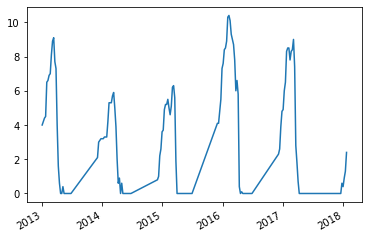

In [15]:
train_two.iloc[190, :].plot()

In [16]:
#### MAIN CELL USED TO GENERATE PREDICTIONS (MIXED MODEL)###

rws = []          #Store predicted rows, station id, best model for dataframe creation
ids = []
model_used = []
sarimax_error = []

for i in range(train_two.shape[0]):
    model = SARIMAX(train_two.iloc[i, :], order=(0,0,0), seasonal_order=(1,0,1,31)).fit()
    model_es = ExponentialSmoothing(train_two.iloc[i, :], seasonal='add', seasonal_periods=31).fit()  
    
    pred = model.predict(start=155, end=155+56)
    pred_es = model_es.predict(start=155, end=155+56)
    pred_flat = [train_two.iloc[i,155]]*57                     #Flat
    pred_mean = [train_two.iloc[i, :].mean()]*57                  #Mean
    pred_last_season = train_two.iloc[i, 155-56:].values              #Last Seasons
    preds = [pred.values, pred_es.values, pred_flat, pred_mean, pred_last_season]

    error_model = np.sqrt(np.sum((pred.values - valid_one.iloc[i, :])**2)/len(pred))
    error_es = np.sqrt(np.sum((pred_es.values - valid_one.iloc[i, :])**2)/len(pred))
    error_flat = np.sqrt(np.sum((pred_flat - valid_one.iloc[i, :])**2)/len(pred))
    error_last_season = np.sqrt(np.sum((pred_last_season - valid_one.iloc[i, :])**2)/len(pred))
    error_mean = np.sqrt(np.sum((pred_mean - valid_one.iloc[i, :])**2)/len(pred))
    sarimax_error.append(error_model)
    
    errors = {"sarimax":error_model, "exponential smoothing":error_es, "flat":error_flat, "last season":error_last_season, "mean":error_mean}
    best_model = np.argmin(list(errors.values()))
    model_used.append(list(errors.keys())[best_model])   #chooses best model
   
    rws.append(list(preds[best_model]))
    ids.append(train_stations.Station[i])
    if i%50 == 0:
        print(i)

#df_pred_655 = pd.DataFrame(rws, columns=test_one.columns)
#df_pred_655[df_pred_655 < 0] = 0
#df_pred_655['Station'] = ids           
                                                                            

0
50
100
150
200
250
300
350
400
450
500
550
600
650


RMSEs:
Flat/random walk gives 9.59, last season gives 8.7, 7.26 for exp, 6.23 for sarimax (0,0,0), seasonal_order=(1,0,1,31), 6.13 with seasonal order (2,0,1,31)

In [17]:
df_pred_655 = pd.DataFrame(rws, columns=test_one.columns)
df_pred_655[df_pred_655 < 0] = 0
df_pred_655['Station'] = ids  


Text(0, 0.5, '')

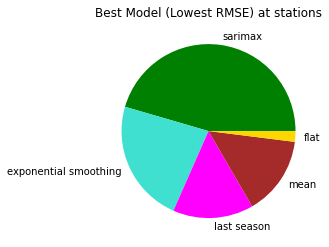

In [18]:
pd.Series(model_used).value_counts().plot(kind = "pie", colors = ["green", "turquoise", "magenta", "brown", "gold"])
plt.title("Best Model (Lowest RMSE) at stations")
plt.ylabel("")


In [19]:
df_pred_655

,2020-01-07 00:00:00,2020-01-14 00:00:00,2020-01-21 00:00:00,2020-01-28 00:00:00,2020-02-04 00:00:00,2020-02-11 00:00:00,2020-02-18 00:00:00,2020-02-25 00:00:00,2020-03-03 00:00:00,2020-03-10 00:00:00,...,2021-05-04 00:00:00,2021-05-11 00:00:00,2021-05-18 00:00:00,2021-05-25 00:00:00,2021-06-01 00:00:00,2021-06-08 00:00:00,2021-06-15 00:00:00,2021-06-22 00:00:00,2021-06-29 00:00:00,Station
0,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,...,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,4.302564,CDEC:ADM
1,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,...,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,12.197853,CDEC:ALP
2,1.452454,2.868373,3.816823,5.053213,5.665574,6.325920,6.506315,5.366698,4.491026,2.751381,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CDEC:BCH
3,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,...,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,5.677692,CDEC:BFL
4,35.040000,34.560000,32.040000,40.920000,41.760000,42.480000,40.440000,35.160000,31.320000,26.760000,...,0.360000,2.400000,1.560000,1.320000,2.160000,2.160000,1.440000,0.240000,1.440000,CDEC:BKL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,8.482025,10.921966,11.383940,12.005895,13.027833,13.429781,14.351703,15.093621,16.075524,14.877420,...,0.812295,0.234216,0.236134,0.238059,0.240014,0.241967,0.243935,0.465911,1.687903,SNOTEL:989_ID_SNTL
651,16.383067,19.690841,20.882581,22.230631,23.847380,24.944428,26.980447,29.268784,31.268803,33.153958,...,27.550535,23.972489,19.779557,15.182176,9.680635,5.471165,2.571570,2.657160,5.235178,SNOTEL:990_WA_SNTL
652,6.199333,6.805382,7.011267,7.536753,8.016690,8.125212,9.197514,9.625573,9.174964,7.384005,...,0.056078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.958109,1.619797,SNOTEL:992_UT_SNTL
653,43.187134,54.007297,56.114606,58.281957,61.869441,64.196811,65.284246,67.971800,71.939257,77.206561,...,82.362777,78.429486,71.416284,64.183016,56.089908,51.576770,44.363594,30.910623,34.917425,SNOTEL:998_WA_SNTL


In [20]:
df_pred_655.to_csv('Mixed000_10131_655.csv')